In [3]:
import itertools
import numpy as np
import numpy.random as npr
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import colors
from matplotlib import gridspec
import matplotlib

import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D  

import scipy.io
from scipy.io import loadmat
from scipy.io import savemat
from scipy import stats
from scipy.special import softmax
from sklearn.metrics import log_loss
import pickle
import copy

%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.family':'Arial'})

In [4]:
subjectNames = ['sam','tabitha','chloe','blanche','b01','b02','b03','b04','b05','b06','b07','b08','b09','b10']

numSubjects = len(subjectNames)

stateNames = ['Persist','Preferred','Random','Avoid']
historyNames = ['(0,0)','(1,0)','(0,1)','(1,1)']

speciesList = np.array([0,0,0,0,1,1,1,1,1,2,2,2,2,2])

speciesColor = ['#fb8072','#8dd3c7','#74add1']
speciesDColor = ['#6a0e03','#1d4c44','#183649']
catColor = [np.array([152,78,163])/255, np.array([77,175,74])/255]

speciesNames = ['monkey','human','human2']

def getPM(N):
    if N == 1:
        return 1
    elif N > 1:
        x = np.zeros([N])
        x[0] = 1
        for i in np.arange(1,N):
            x[i] = -1 * x[i-1]
        return x

######################################

analysis = []
data = []
data0 = []


for i in range(numSubjects):
    with open('analysis/'+subjectNames[i]+'.pickle', 'rb') as f:
        [A] = pickle.load(f)
    analysis.append(A)
    with open('data/'+subjectNames[i]+'.pickle', 'rb') as f:
        [D] = pickle.load(f)
    data.append(D)
    data0.append(D)


categoryNames = ['Perseveration',
                 'Random search',
                 'Rule random, \n Exploration',
                 'Rule favored, \n Exploration',
                 'Rule preferred, \n No exploration',
                 'Rule persist, \n No exploration']

subjectNames = ['1','2','3','4','1','2','3','4','5','1','2','3','4','5']



In [3]:
Lc = []
LcNonRule = []

for i in range(numSubjects):
    Lc.append(analysis[i]['categoryAnalysis']['LCategory'][3,:])
    Y = []
    X = analysis[i]['categoryAnalysis']['ellNonRuleExplore2']
    for j in range(len(X)):
        for k in range(len(X[j])):
            # print(X[j][k])
            if len(X[j][k]) > 0:
                Y.append(np.array(X[j][k]))
        #print(np.array(X[j]).shape)
        #Y.append(np.array(X[j]).flatten())
    LcNonRule.append(np.concatenate(Y))



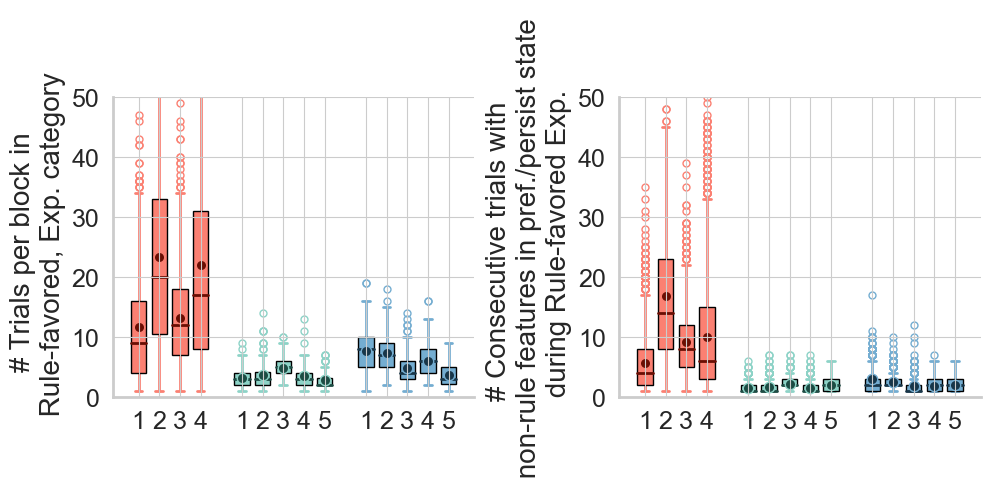

In [4]:
#fig, ax = plt.subplots(figsize=(7,4))

fig, ax = plt.subplots(ncols=2,nrows=1,sharex=False,sharey=False,figsize=(4*2*1.4,3*1.3))


for p in range(2): # subplots
    xPos = []

    pos = -0.8*2
    for spInd in range(3): # Species
        idx = np.where(np.array(speciesList) == spInd)[0]

        prop1 = dict(color=speciesColor[spInd],linewidth=2)
        prop2 = dict(color=speciesDColor[spInd],linewidth=2)
        prop3 = dict(markeredgecolor=speciesColor[spInd],marker='.',markersize=10,linewidth=4)
        prop4 = dict(markerfacecolor=speciesDColor[spInd],
                     markeredgecolor=speciesColor[spInd],marker='.',markersize=15)

        pos += 0.8
        for i in idx:

            pos += 0.8

            xPos.append(pos)
            if p == 0:
                data = Lc[i]
            else:
                data = LcNonRule[i]
            idx = np.where(data > 0)[0]
            bp = ax[p].boxplot(data[idx],positions=[pos],widths=0.6,patch_artist=True,medianprops=prop2,whiskerprops=prop1,
                            capprops=prop1,flierprops=prop3,zorder=0,showmeans=True,meanprops=prop4)

            bp['boxes'][0].set_facecolor(speciesColor[speciesList[i]])

    ax[p].set_xlim([xPos[0]-1,xPos[-1]+1])
    ax[p].set_ylim([0,50])
    ax[p].set_xticks(xPos)
    ax[p].set_xticklabels(subjectNames,fontsize=18) #,rotation=30

#     ax[p].text(1.5, -7, 'Monkeys', ha='center', size=20)
#     ax[p].text(6.8, -7, 'Humans', ha='center', size=20)
    # fig.text(0.5, -0.25, 'N = '+str(Lc5Sim[0].shape[0])+' simulations', ha='center', size=12)

    if p == 0:
        ax[p].set_ylabel('# Trials per block in \n Rule-favored, Exp. category',fontsize=20)
    else:
        ax[p].set_ylabel('# Consecutive trials with \n non-rule features in pref./persist state \n during Rule-favored Exp.',fontsize=20)        

    ax[p].tick_params(axis='both',direction='out',width=2)
    ax[p].tick_params(axis='x',length=6,labelsize=18)
    ax[p].tick_params(axis='y',length=6,labelsize=18)
    # change all spines
    for axis in ['top','bottom','left','right']:
        ax[p].spines[axis].set_linewidth(2)

    ax[p].spines['right'].set_visible(False)
    ax[p].spines['top'].set_visible(False)

    ax[p].set_axisbelow(True)
    
plt.subplots_adjust(wspace=0.4, 
                    hspace=0.0)

# plt.savefig('longRuleFavExpEvd.eps', format='eps')
plt.show()

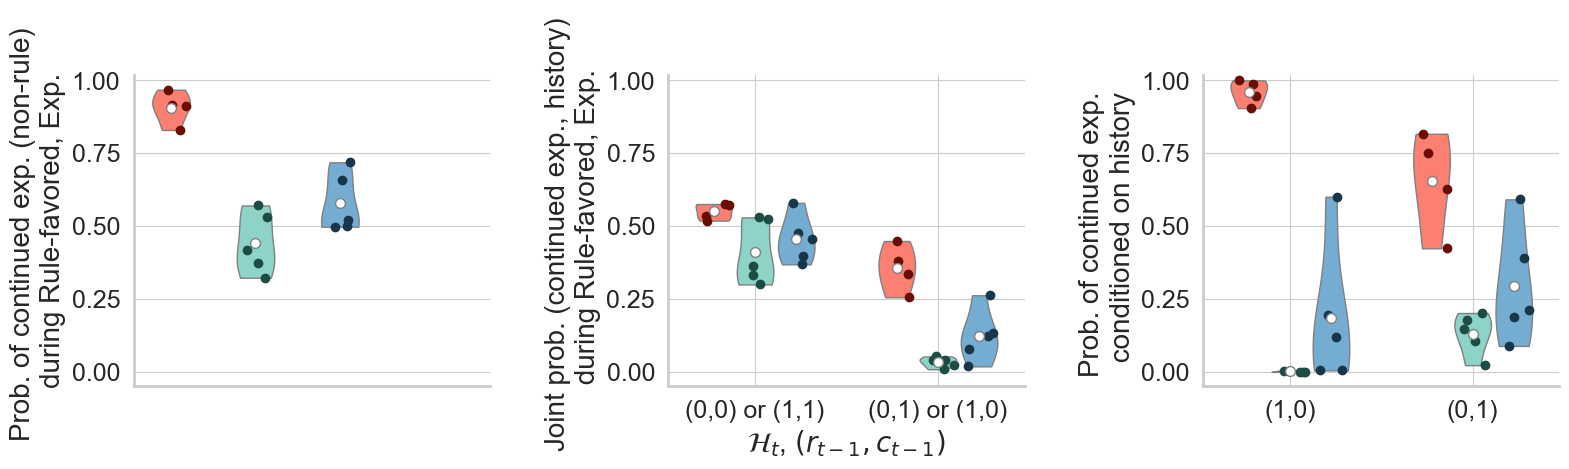

In [9]:
Dat = dict()
Dat[0] = np.zeros((len(analysis))) # Probability of continued exploration
Dat[1] = np.zeros((len(analysis),2)) # Joint probability of continued exploration (with history)
Dat[2] = np.zeros((len(analysis),2)) # Probability of continued exploration conditioned on history
Dat[3] = np.zeros((len(analysis),2)) # Probability of history under continued exploration
for i in range(len(analysis)):
    D = np.zeros((4,5))
    X = np.around(analysis[i]['categoryAnalysis']['stateNonRuleExplore']['pz_S0C'],3)
    X[np.isnan(X)] = 0
    D[:2,0] = X[0] # conditional probability of exploration
    X = np.around(analysis[i]['categoryAnalysis']['stateNonRuleExplore']['pH_S0C'],3)
    X[np.isnan(X)] = 0
    D[:4,1] = X # conditional probability of history
    X = np.around(analysis[i]['categoryAnalysis']['stateNonRuleExplore']['pz_HS0C'],3)
    X[np.isnan(X)] = 0
    D[:4,3] = np.around(X[0,:],3) # conditional probability of exploration (also conditioned on history)
    y1 = np.multiply(D[:4,1],D[:4,3])
    Dat[0][i] = np.around(np.sum(y1),3) # conditional probability of exploration
    Dat[1][i,0] = np.around(np.sum(y1[[0,3]]),3) # positive feedback history (direct and indirect)
    Dat[1][i,1] = np.around(np.sum(y1[[1,2]]),3) # negative feedback history (direct and indirect)
    Dat[2][i,0] = np.around(D[1,3],3)  # conditioned on NC+
    Dat[2][i,1] = np.around(D[2,3],3) # conditioned on C-
    y1 = D[:4,1]
    Dat[3][i,0] = np.around(np.sum(y1[[0,3]]),3) # positive feedback history (direct and indirect)
    Dat[3][i,1] = np.around(np.sum(y1[[1,2]]),3) # negative feedback history (direct and indirect)


fig, ax = plt.subplots(ncols=3,nrows=1,sharex=False,sharey=False,figsize=(4*2*2.3,3*1.35))#figsize=(4*2*3,3*2))

vpWidth = 0.5

for k in range(3): # subplots
    data = Dat[k]
    for i in np.unique(speciesList):
        idx = np.where(np.array(speciesList) == i)[0]

        for j in range(data.ndim):
            if data.ndim > 1:
                pdat = data[idx,j]
            else:
                pdat = data[idx]

            vp = ax[k].violinplot(pdat,[j*2+(i+i*(2-data.ndim))*0.45],showextrema=False,widths=vpWidth*0.8)

            x = npr.rand(idx.shape[0]) * (vpWidth) * (0.3)
            pm = getPM(idx.shape[0])
            x = np.multiply(x,pm)+j*2+(i+i*(2-data.ndim))*0.45+0.025#-0.1#i-0.1 #np.multiply(x,pm) + i

            ax[k].scatter(x,pdat,color=speciesDColor[i])

            for pc in vp['bodies']:
                pc.set_facecolor(speciesColor[i])
                pc.set_edgecolor('gray')
                pc.set_alpha(1)

            ax[k].scatter(j*2+(i+i*(2-data.ndim))*0.45,np.mean(pdat),color='white',s=50,edgecolors='gray')

    ax[k].set_ylim([-0.05,1.02])
    if k == 0:
        ax[k].set_xlim([-0.4,3.4])
        ax[k].set_xticks([])
    else:
        ax[k].set_xlim([-0.5,3.4])
        ax[k].set_xticks([0.45,2.45])
        if k == 1:
            ax[k].set_xticklabels(['(0,0) or (1,1)','(0,1) or (1,0)'],fontsize=18)
        else:
            ax[k].set_xticklabels(['(1,0)','(0,1)'],fontsize=18)

    ax[k].set_yticks([0,0.25,0.5,0.75,1])

    if k == 0:
        ax[k].set_ylabel('Prob. of continued exp. (non-rule) \nduring Rule-favored, Exp.',fontsize=20)
    elif k == 1:
        ax[k].set_ylabel('Joint prob. (continued exp., history) \n during Rule-favored, Exp.',fontsize=20)
    else:
        ax[k].set_ylabel('Prob. of continued exp. \n conditioned on history',fontsize=20)


    if k == 1:
        ax[k].set_xlabel('$\mathcal{H}_t$, $(r_{t-1},c_{t-1})$',fontsize=20)

    ax[k].tick_params(axis='both',labelsize= 18,direction='out',width=2, length=6)
    # change all spines
    for axis in ['top','bottom','left','right']:
        ax[k].spines[axis].set_linewidth(2)

    ax[k].spines['right'].set_visible(False)
    ax[k].spines['top'].set_visible(False)

plt.subplots_adjust(wspace=0.5,
                    hspace=0.0)
# plt.savefig('longRuleFavExpCause.eps', format='eps')

In [7]:
def calcBootstrp(data1, data2):
    data1 = np.array(data1)
    data2 = np.array(data2)
    s = stats.ttest_ind(data1, data2, equal_var=False)
    t = s.statistic

    data1_hat = data1-np.mean(data1) + np.mean(np.concatenate([data1, data2]))
    data2_hat = data2-np.mean(data2) + np.mean(np.concatenate([data1, data2]))
    t_stars = []
    for i in range(10000):
        data1_samp = np.random.choice(data1_hat,size=data1.shape[0])
        data2_samp = np.random.choice(data2_hat,size=data2.shape[0])
        s = stats.ttest_ind(data1_samp, data2_samp, equal_var=False)
        t_stars.append(s.statistic)

    return t, t_stars



In [16]:
hmn = Dat[2][4:,1]
mmn = Dat[2][:4,1]
t, t_stars = calcBootstrp(hmn,mmn)
# plt.hist(t_stars,1000)
# plt.xlim([-50,50])
print(np.mean(t_stars<=t))

/var/folders/d0/w_19qmbx12q36d9zs46hfymm0000gn/T/ipykernel_83727/1003699321.py:13: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  s = stats.ttest_ind(data1_samp, data2_samp, equal_var=False)


0.015


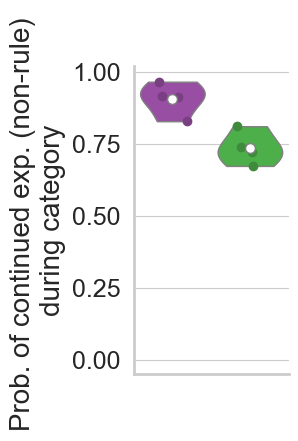

In [30]:
Dat = np.zeros([4,2])
idx = np.where(np.array(speciesList) == 0)[0] # monkeys only
for k in idx:
    X = np.sum(analysis[k]['categoryAnalysis']['catEndReasStats'],0)#[5],0)
    X = X/np.sum(X)
#     print(X/np.sum(X))
    Dat[k,0] = X[0]
    X = np.sum(analysis[k]['categoryAnalysis']['catEndReasStats2'],0)#[5],0)
    X = X/np.sum(X)
    Dat[k,1] = X[0]



fig, ax = plt.subplots(ncols=1,nrows=1,sharex=False,sharey=False,figsize=(2,4))

vpWidth = 0.5


for i in range(2): # categories
    data = Dat[:,i]
    vp = ax.violinplot(data,[i*0.6],showextrema=False,widths=vpWidth)

    x = npr.rand(4) * (vpWidth) * (0.3)
    pm = getPM(4)
    x = np.multiply(x,pm)+i*0.6#-0.1#i-0.1 #np.multiply(x,pm) + i

    ax.scatter(x,data,color=catColor[i]*0.8)

    for pc in vp['bodies']:
        pc.set_facecolor(catColor[i])
        pc.set_edgecolor('gray')
        pc.set_alpha(1)

    ax.scatter(i*0.6,np.mean(data),color='white',s=50,edgecolors='gray')

ax.set_ylim([-0.05,1.02])
ax.set_xlim([-0.3,0.9])
ax.set_yticks([0,0.25,0.5,0.75,1.0])
ax.set_xticks([])

ax.set_ylabel('Prob. of continued exp. (non-rule) \nduring category',fontsize=20)

ax.tick_params(axis='both',labelsize= 18,direction='out',width=2, length=6)
# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.subplots_adjust(wspace=0.5,
#                     hspace=0.0)
# plt.savefig('transProb_Cat3.eps', format='eps')

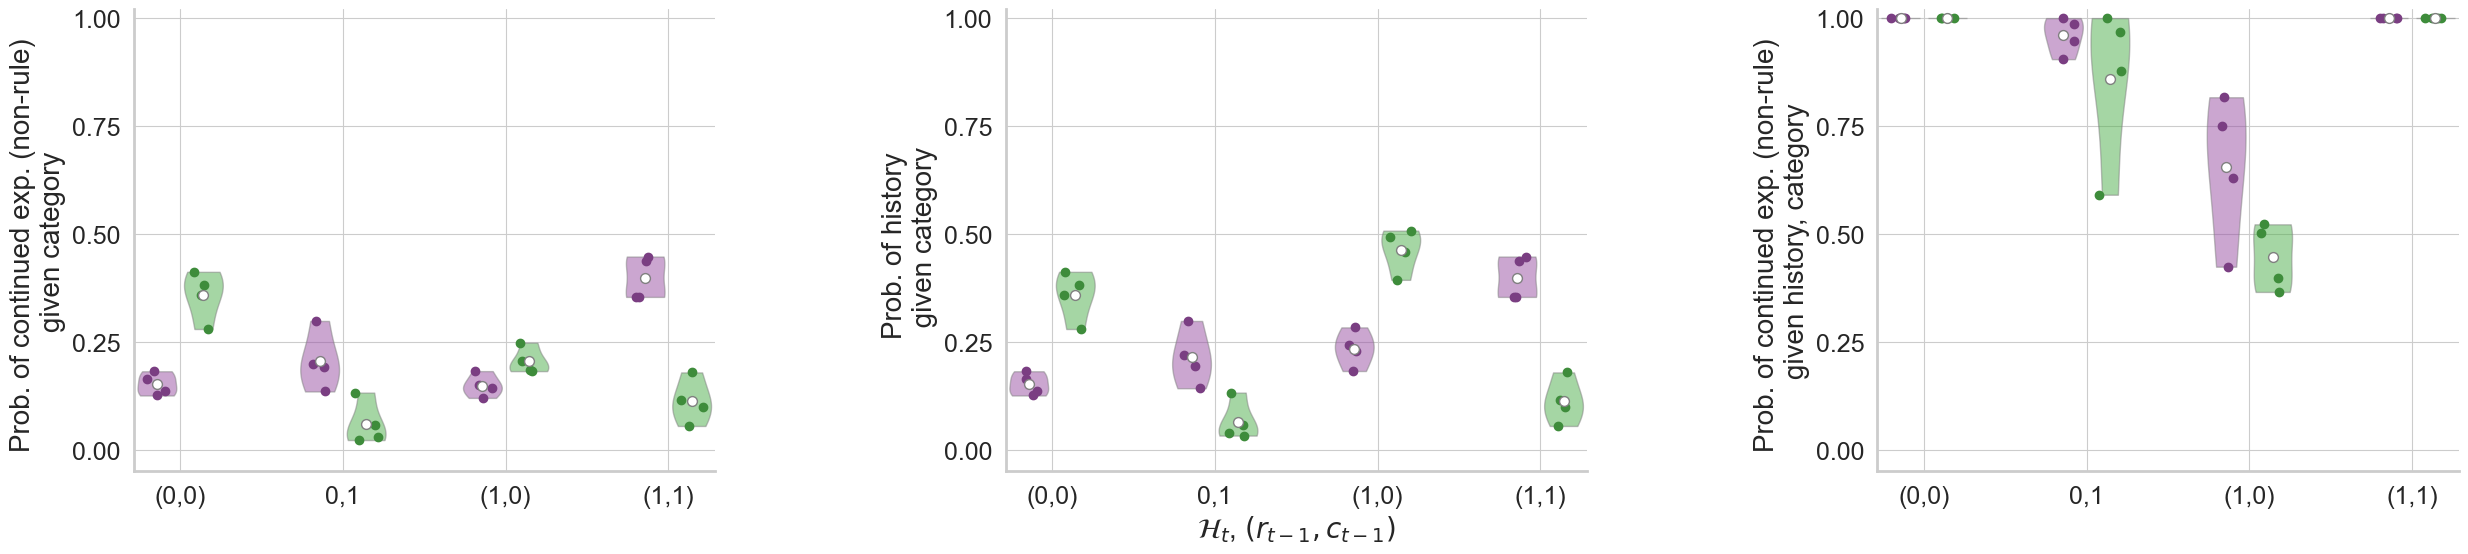

In [5]:
Dat = dict()
idx = np.where(np.array(speciesList) == 0)[0] # monkeys only
Dat[0] = np.zeros([2*idx.size,4])
Dat[1] = np.zeros([2*idx.size,4])
Dat[2] = np.zeros([2*idx.size,4])
for l in range(2): # Category
    for k in idx: # subjects
        if l == 0:
            D = analysis[k]['categoryAnalysis']['catEndReasStats']#[5]
        else:
            D = analysis[k]['categoryAnalysis']['catEndReasStats2']#[5]

        D = D/np.sum(D) # joint prob cont. exploration, history | category
        Dat[0][k+l*4,:] = D[:,0]
        Y = np.sum(D,1,keepdims=True) # prob of hist, given category
        Dat[1][k+l*4,:] = Y[:,0]
        # prob exp, given history and cont. explore
        # X[np.isnan(X)] = 0
        Dat[2][k+l*4,:] = D[:,0]/Y[:,0]

fig, ax = plt.subplots(ncols=3,nrows=1,sharex=False,sharey=False,figsize=(4*2.5*3,3*2))

vpWidth = 0.5

for k in range(3): # subplots
    for m in range(4): # histories
        D1 = []
        D2 = []
        for i in range(2): # categories
            didx = np.arange(idx.size) + i*idx.size
            data = Dat[k][didx,m]
            vp = ax[k].violinplot(data,[i*0.6+m*2.1],showextrema=False,widths=vpWidth)

            x = npr.rand(didx.shape[0]) * (vpWidth) * (0.3)
            pm = getPM(didx.shape[0])
            x = np.multiply(x,pm)+i*0.6+m*2.1#-0.1#i-0.1 #np.multiply(x,pm) + i

            ax[k].scatter(x,data,color=catColor[i]*0.8)

            for pc in vp['bodies']:
                pc.set_facecolor(catColor[i])
                pc.set_edgecolor('gray')
                pc.set_alpha(0.5)

            ax[k].scatter(i*0.6 +m*2.1,np.mean(data),color='white',s=50,edgecolors='gray')  

    ax[k].set_ylim([-0.05,1.02])
    ax[k].set_xlim([-0.3,7.2])
    ax[k].set_xticks([0.3,2.4,4.5,6.6])
    ax[k].set_yticks([0,0.25,0.5,0.75,1.0])
    ax[k].set_xticklabels(['(0,0)','0,1', '(1,0)','(1,1)'],fontsize=18)
    if k == 0:
        ax[k].set_ylabel('Prob. of continued exp. (non-rule) \ngiven category',fontsize=20)
    elif k == 1:
        ax[k].set_ylabel('Prob. of history \n given category',fontsize=20)
    else:
        ax[k].set_ylabel('Prob. of continued exp. (non-rule) \ngiven history, category',fontsize=20)

    if k == 1:
        ax[k].set_xlabel('$\mathcal{H}_t$, $(r_{t-1},c_{t-1})$',fontsize=20)

    ax[k].tick_params(axis='both',labelsize= 18,direction='out',width=2, length=6)
    # change all spines
    for axis in ['top','bottom','left','right']:
        ax[k].spines[axis].set_linewidth(2)

    ax[k].spines['right'].set_visible(False)
    ax[k].spines['top'].set_visible(False)
    
plt.subplots_adjust(wspace=0.5, 
                    hspace=0.0)
# plt.savefig('rewRtComp_2Cats.eps', format='eps')

In [8]:
mmn1 = Dat[1][4:,3]
mmn2 = Dat[1][:4,3]
t, t_stars = calcBootstrp(mmn1,mmn2)
# plt.hist(t_stars,1000)
# plt.xlim([-50,50])
print(np.mean(t_stars<=t))

/var/folders/d0/w_19qmbx12q36d9zs46hfymm0000gn/T/ipykernel_83727/1003699321.py:13: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  s = stats.ttest_ind(data1_samp, data2_samp, equal_var=False)


0.0059
